# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Было принято решение построить систему, способную проанализировать поведение клиента и спрогнозировать, уйдёт он из банка в ближайшее время или нет. 

В нашем распоряжении исторические данные о поведении клиентов и расторжении договоров с банком. Обучим на них разные модели и выберем одну с предельно большим значением *F1*-меры. 

**Цель исследования**: построить модель для задачи классификации, которая сможет спрогнозировать уход клиента из банка, со значением *F1*-метрики не менее 0.59.

**Ход исследования**

Данные для исследования получим из файлов `Churn.csv`. О качестве данных ничего не известно, поэтому перед обучением моделей понадобится их проверить. Найдем ошибки данных и оценим их влияние на исследование. На этапе подготовки попробуем исправить критичные из них.
 
Исследование пройдет в пять этапов:
 1. Изучение данных.
 2. Подготовка данных.
 3. Ислледование задачи.
 4. Балансировка классов.
 5. Тестирование модели.

## Изучение данных из файла

Для начала импортируем необходимые в исследовании библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
import warnings
from pandas.core.common import SettingWithCopyWarning

Прочитаем файл `Churn.csv` из каталога `datasets` и сохраним его в переменной `churn`, столбец `RowNumber` сделаем индексом.

In [2]:
churn = pd.read_csv('/datasets/Churn.csv', index_col=0)

Составим представление о данных, отобразив на экране первые десять строк таблицы.

In [3]:
churn.head(10)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0


Получим общую информацию о таблице методом `info()`.

In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


Итак, таблица `churn` состоит из 13 столбцов:
* CustomerId — уникальный идентификатор клиента;
* Surname — фамилия;
* CreditScore — кредитный рейтинг;
* Geography — страна проживания;
* Gender — пол;
* Age — возраст;
* Tenure — сколько лет человек является клиентом банка;
* Balance — баланс на счёте;
* NumOfProducts — количество продуктов банка, используемых клиентом;
* HasCrCard — наличие кредитной карты;
* IsActiveMember — активность клиента;
* EstimatedSalary — предполагаемая зарплата;
* Exited — факт ухода клиента.

### Выводы

В нашем распоряжении таблица `churn`, содержащая данные о поведении клиентов банка и факта расторжения договора с ним. 

Предварительно можно утверждать, что, данных достаточно для обучения моделей. Но встречаются пропуски в данных, а в названиях колонок — расхождения с хорошим стилем.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Подготовка данных

Приведем наименования столбцов таблицы к хорошему стилю: запишем их в нижнем змеином регистре.

In [5]:
churn.columns = (['customer_id', 'surname', 'credit_score', 'geography', 'gender',
                 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
                 'is_active_member', 'estimated_salary', 'exited'])

В столбце `tenure` присутствуют пропуски, попробуем их заполнить, на основании значений признака схожих клиентов. Для этого определим наиболее коррелирующие со столбцом признаки таблицы. 

In [6]:
churn.corr(method='pearson')

,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
customer_id,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
credit_score,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
num_of_products,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_cr_card,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
is_active_member,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.006248,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


Корреляция между столбцом `tenure` и другими столбцами таблицы очень слабая, чтобы ориентироваться на них при заполнении пропусков, поэтому заменим пропущенные значения медианным значением столбца.

In [7]:
churn['tenure'] = churn['tenure'].fillna(churn['tenure'].median())

Целевым признаком нашей таблицы является столбец `exited`: запишем его в переменную `target`. Влияющими признаками в нашем случае будут столбцы `credit_score`, `geography`, `gender`, `age`, `tenure`, `balance`, `num_of_products`, `has_cr_card`, `is_active_member` и `estimated_salary`. 

Столбцы `customer_id`  и `surname` исключим из обучения нашей модели, т.к. их значения являются уникальными для каждого клиента.

In [8]:
features = churn.drop(['exited', 'customer_id', 'surname'], axis=1)
target = churn['exited']

Преобразуем категориальные признаки `geography` и `gender` в количественные функцией `get_dummies()` библиотеки `pandas`. Чтобы избежать дамми-ловушку, укажем значение параметра `drop_first` = True.

In [9]:
features = pd.get_dummies(features, drop_first=True)

Поделим исходный набор данных на обучающую, валидационную и тестовую выборки в отношении 2:1:1 с помощью метода `train_test_split()`: сначала применим его ко всему набору данных, отделив обучающую выборку, затем оставшийся набор данных разделим на валидационный и тестовый.

In [10]:
features_train, features_valid_and_test, target_train, target_valid_and_test = train_test_split(features, 
                                                                                                target,
                                                                                                test_size=0.4,
                                                                                                random_state=777)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_and_test,
                                                                            target_valid_and_test,
                                                                            test_size=0.5,
                                                                            random_state=777)

Проверим размеры полученных выборок функцией `shape`.

In [11]:
print(features_train.shape, features_valid.shape, features_test.shape)

(6000, 11) (2000, 11) (2000, 11)


В данных присутствуют количественные признаки `credit_score`, `age`, `tenure`, `balance`, `num_of_products`, `estimated_salary` с разными разбросами значений. Нормализуем их с помощью функции `StandardScaler()` библиотеки `sklearn`.

In [12]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=SettingWithCopyWarning)
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])

### Выводы

На этапе подготовки данных были обнаружены и устранены две проблемы:
* нарушения стиля в заголовках столбцов;
* пропущенные значения.

Разделив имеющиеся данные на выборки и определив влияющие и целевой признаки, перейдем к обучению моделей. 

## Исследование задачи

Для решения задачи классификации будем использовать три модели:
* дерево решений;
* случайный лес;
* логистическая регрессия.

Определим лучшее дерево решений, изменяя значения гиперпараметров `max_depth` (максимальная глубина дерева), `min_samples_split` (минимальное число объектов, необходимое для того, чтобы узел дерева мог расщепиться) и `min_samples_leaf` (минимальное число объектов в листьях).

In [13]:
param_grid = {'max_depth': range(1, 16), 'criterion': ['gini', 'entropy']}
clf = (GridSearchCV(DecisionTreeClassifier(random_state=777),
                    param_grid, cv=5, scoring='f1'))
best_model = (clf.fit(pd.concat([features_train] + [features_valid]), 
                      pd.concat([target_train] + [target_valid])))
print(f'Лучшая модель на валидационной выборке: {best_model.best_estimator_}')
print(f'F1-мера наилучшей модели на валидационной выборке: '
      f'{best_model.best_score_}')

Лучшая модель на валидационной выборке: DecisionTreeClassifier(max_depth=7, random_state=777)
F1-мера наилучшей модели на валидационной выборке: 0.5622310972414513


Лучшим деревом решений с `F1` = 0.56 является дерево со значением гиперпараметров `max_depth` = 7, и дефолтными `criterion` = gini.

Найдем лучшие гиперпараметры для модели случайный лес.

In [14]:
param_grid = {'n_estimators': [10, 20, 30, 40, 50 , 60, 70, 80, 90, 100],
              'max_depth': range(1, 16), 'criterion': ['gini', 'entropy']}
clf = (GridSearchCV(RandomForestClassifier(random_state=777),
                    param_grid, cv=5, scoring='f1'))
best_model = (clf.fit(pd.concat([features_train] + [features_valid]), 
                      pd.concat([target_train] + [target_valid])))
print(f'Лучшая модель на валидационной выборке: {best_model.best_estimator_}')
print(f'F1-мера наилучшей модели на валидационной выборке: '
      f'{best_model.best_score_}')

Лучшая модель на валидационной выборке: RandomForestClassifier(max_depth=15, n_estimators=70, random_state=777)
F1-мера наилучшей модели на валидационной выборке: 0.5919492752800685


Случайный лес с гиперпараметрами `max_depth` = 15 и `n_estimators` = 70 позволил добиться лучшего `F1` = 0.59.

Для логистической регрессии лучшие гиперпараметры подберем методом `GridSearchCV()`.

In [15]:
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0], 'penalty': ['l1', 'l2']}
clf = (GridSearchCV(LogisticRegression(random_state=777, solver='liblinear'), 
                    param_grid, cv=5, scoring='f1'))
best_model = (clf.fit(pd.concat([features_train] + [features_valid]), 
                      pd.concat([target_train] + [target_valid])))
print(f'Лучшая модель на валидационной выборке: {best_model.best_estimator_}')
print(f'F1-мера наилучшей модели на валидационной выборке: '
      f'{best_model.best_score_}')

Лучшая модель на валидационной выборке: LogisticRegression(C=10.0, penalty='l1', random_state=777, solver='liblinear')
F1-мера наилучшей модели на валидационной выборке: 0.304949250234638


Гиперпараметры логистической регрессии `C` = 0.1, `penalty` = l2, `solver` = liblinear помогли модели достичь значения `F1` = 0.3.

### Выводы

В качестве моделей обучения были выбраны дерево решений, случайный лес и логистическая регрессия. Изменяя значения гиперпараметров мы смогли достичь на валидационной выборке лучшего значения `F1`-меры. Лучшее качество показала модель случайного леса, состоящая из 70 деревьев с глубиной дерева, равной 15 (`F1` = 0.59). 

На следующем этапе проверим, наблюдается ли в данных дисбаланс классов, и избавимся от него для улучшения качества модели обучения.

## Борьба с дисбалансом

Проверим, существует ли дисбаланс классов в данных. Если доля объектов однго класса окажется слишком низкой, а другого — слишком большой, то возможен «перекос» в сторону мажоритарного класса, т.е. с большей вероятностью новые наблюдения модель обучения будет относить к преобладающему классу. 

In [32]:
target.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

<AxesSubplot:>

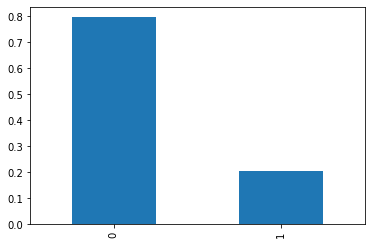

In [16]:
target.value_counts(normalize=True).plot(kind='bar')

Количество объектов положительного класса (1) почти в 4 раза меньше объектов отрицательного класса (0). 

Устраним дисбаланс классов тремя способами и проверим, увеличится ли качество модели по величине значения `F1`-метрики:
* взвешивание классов;
* увеличение числа объектов миноритарного класса;
* сокращение числа объектов мажоритарного класса.

### Взвешивание классов

Придадим объектам редкого класса больший вес, указав в параметре `class_weight` значение balanced.

In [17]:
param_grid = {'max_depth': range(1, 16), 'criterion': ['gini', 'entropy']}
clf = (GridSearchCV(DecisionTreeClassifier(random_state=777, 
                                           class_weight='balanced'),
                    param_grid, cv=5, scoring='f1'))
best_model = (clf.fit(pd.concat([features_train] + [features_valid]), 
                      pd.concat([target_train] + [target_valid])))
print(f'Лучшая модель на валидационной выборке: {best_model.best_estimator_}')
print(f'F1-мера наилучшей модели на валидационной выборке: '
      f'{best_model.best_score_}')

Лучшая модель на валидационной выборке: DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=7, random_state=777)
F1-мера наилучшей модели на валидационной выборке: 0.5600830768060199


In [18]:
param_grid = {'n_estimators': [10, 20, 30, 40, 50 , 60, 70, 80, 90, 100],
              'max_depth': range(1, 16), 'criterion': ['gini', 'entropy']}
clf = (GridSearchCV(RandomForestClassifier(random_state=777,
                                           class_weight='balanced'),
                    param_grid, cv=5, scoring='f1'))
best_model = (clf.fit(pd.concat([features_train] + [features_valid]), 
                      pd.concat([target_train] + [target_valid])))
print(f'Лучшая модель на валидационной выборке: {best_model.best_estimator_}')
print(f'F1-мера наилучшей модели на валидационной выборке: '
      f'{best_model.best_score_}')

Лучшая модель на валидационной выборке: RandomForestClassifier(class_weight='balanced', max_depth=9, random_state=777)
F1-мера наилучшей модели на валидационной выборке: 0.6112606637667535


In [19]:
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0], 'penalty': ['l1', 'l2']}
clf = (GridSearchCV(LogisticRegression(random_state=777, 
                                       solver='liblinear',
                                       class_weight='balanced'), 
                    param_grid, cv=5, scoring='f1'))
best_model = (clf.fit(pd.concat([features_train] + [features_valid]), 
                      pd.concat([target_train] + [target_valid])))
print(f'Лучшая модель на валидационной выборке: {best_model.best_estimator_}')
print(f'F1-мера наилучшей модели на валидационной выборке: '
      f'{best_model.best_score_}')

Лучшая модель на валидационной выборке: LogisticRegression(C=0.001, class_weight='balanced', random_state=777,
                   solver='liblinear')
F1-мера наилучшей модели на валидационной выборке: 0.5006307427731767


#### Выводы

Применив взвешивание классов, мы смогли улучшить качество моделей обучения. Наиболее точной оказалась модель случайного леса, состоящая из 100 деревьев с глубиной дерева, равной 9 (F1-метрика = 0.61).

### Увеличение числа объектов миноритарного класса

Избавимся от дисбаланса классов, увеличив количество объектов миноритарного класса в четыре раза. Для этого создадим специальную функцию `upsample()`.

In [20]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=777)
    
    return features_upsampled, target_upsampled

Передадим в функцию обучающие выборки, значение параметра `repeat` укажем равное четырем.

In [21]:
features_upsampled, target_upsampled = upsample(pd.concat([features_train] + [features_valid]), 
                                                pd.concat([target_train] + [target_valid]), 4)

Обучим модели на увеличенных выборках `features_upsampled` и `target_upsampled`.

In [22]:
param_grid = {'max_depth': range(1, 16), 'criterion': ['gini', 'entropy']}
clf = (GridSearchCV(DecisionTreeClassifier(random_state=777),
                    param_grid, cv=5, scoring='f1'))
best_model = (clf.fit(features_upsampled, target_upsampled))
print(f'Лучшая модель на валидационной выборке: {best_model.best_estimator_}')
print(f'F1-мера наилучшей модели на валидационной выборке: '
      f'{best_model.best_score_}')

Лучшая модель на валидационной выборке: DecisionTreeClassifier(max_depth=15, random_state=777)
F1-мера наилучшей модели на валидационной выборке: 0.9049964250046949


In [23]:
param_grid = {'n_estimators': [10, 20, 30, 40, 50 , 60, 70, 80, 90, 100],
              'max_depth': range(1, 16), 'criterion': ['gini', 'entropy']}
clf = (GridSearchCV(RandomForestClassifier(random_state=777),
                    param_grid, cv=5, scoring='f1'))
best_model = (clf.fit(features_upsampled, target_upsampled))
print(f'Лучшая модель на валидационной выборке: {best_model.best_estimator_}')
print(f'F1-мера наилучшей модели на валидационной выборке: '
      f'{best_model.best_score_}')

Лучшая модель на валидационной выборке: RandomForestClassifier(max_depth=15, n_estimators=80, random_state=777)
F1-мера наилучшей модели на валидационной выборке: 0.9498870484684389


In [24]:
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0], 'penalty': ['l1', 'l2']}
clf = (GridSearchCV(LogisticRegression(random_state=777, solver='liblinear'), 
                    param_grid, cv=5, scoring='f1'))
best_model = (clf.fit(features_upsampled, target_upsampled))
print(f'Лучшая модель на валидационной выборке: {best_model.best_estimator_}')
print(f'F1-мера наилучшей модели на валидационной выборке: '
      f'{best_model.best_score_}')

Лучшая модель на валидационной выборке: LogisticRegression(C=0.001, penalty='l1', random_state=777, solver='liblinear')
F1-мера наилучшей модели на валидационной выборке: 0.7049347997645121


#### Выводы

Увеличив количество объектов редкого класса в обучающей выборке, мы смогли достигнуть максимальное значение F1-меры = 0.95 для модели случайного леса со значениями гиперпараметров `max_depth` = 15, `n_estimators` = 80.

### Уменьшение числа объектов мажоритарного класса

Сбалансируем данные, уменьшив количество объектов мажоритарного класса. Реализуем подходящую функцию `downsample()`.

In [25]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=777)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=777)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=777)
    
    return features_downsampled, target_downsampled

Передадим обучающие выборки в новую функцию, в параметре `fraction` укажем 0.25.

In [26]:
features_downsampled, target_downsampled = downsample(pd.concat([features_train] + [features_valid]), 
                                                pd.concat([target_train] + [target_valid]), 0.25)

Обучим модели на уменьшенных выборках, изменяя значения гиперпараметров.

In [27]:
param_grid = {'max_depth': range(1, 16), 'criterion': ['gini', 'entropy']}
clf = (GridSearchCV(DecisionTreeClassifier(random_state=777),
                    param_grid, cv=5, scoring='f1'))
best_model = (clf.fit(features_downsampled, target_downsampled))
print(f'Лучшая модель на валидационной выборке: {best_model.best_estimator_}')
print(f'F1-мера наилучшей модели на валидационной выборке: '
      f'{best_model.best_score_}')

Лучшая модель на валидационной выборке: DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=777)
F1-мера наилучшей модели на валидационной выборке: 0.7586713762238619


In [28]:
param_grid = {'n_estimators': [10, 20, 30, 40, 50 , 60, 70, 80, 90, 100],
              'max_depth': range(1, 16), 'criterion': ['gini', 'entropy']}
clf = (GridSearchCV(RandomForestClassifier(random_state=777),
                    param_grid, cv=5, scoring='f1'))
best_model = (clf.fit(features_downsampled, target_downsampled))
print(f'Лучшая модель на валидационной выборке: {best_model.best_estimator_}')
print(f'F1-мера наилучшей модели на валидационной выборке: '
      f'{best_model.best_score_}')

Лучшая модель на валидационной выборке: RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=70,
                       random_state=777)
F1-мера наилучшей модели на валидационной выборке: 0.7719072121482509


In [29]:
param_grid = {'C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0], 'penalty': ['l1', 'l2']}
clf = (GridSearchCV(LogisticRegression(random_state=777, solver='liblinear'), 
                    param_grid, cv=5, scoring='f1'))
best_model = (clf.fit(features_downsampled, target_downsampled))
print(f'Лучшая модель на валидационной выборке: {best_model.best_estimator_}')
print(f'F1-мера наилучшей модели на валидационной выборке: '
      f'{best_model.best_score_}')

Лучшая модель на валидационной выборке: LogisticRegression(C=0.05, random_state=777, solver='liblinear')
F1-мера наилучшей модели на валидационной выборке: 0.7085753298501956


#### Выводы

Уменьшив количество объектов мажоритарного класса в обучающей выборке, мы смогли получить лучшее значение F1-меры, равное 0.77, на случайном лесе, состоящим из 70 деревьев с глубиной дерева, равной 8.

### Выводы

В качестве способов балансировки классов были опробованы взвешивание классов, upsampling и downsampling. После устранения дисбаланса мы обучили три модели: дерево решений, случайный лес и логистическую регрессию, подбирая наилучшие значения гиперпараметров.

Наиболее точной оказалась модель случайного леса, состоящая из 80 деревьев с глубиной дерева 15, обученная на выборке с увеличенным числом объектов миноритарного класса (1). Перейдем к проверки модели на тестовой выборке.

## Тестирование модели

Обучим выбранную модель на увеличенной выборке, затем проверим ее на тестовой выборке.

In [30]:
model = RandomForestClassifier(max_depth=15, n_estimators=80, random_state=777)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))

F1: 0.6270022883295194


Значение F1-метрики модели на тестовой выборке = 0.63, что удовлетворяет цели исследования.

Построем график ROC-кривой, который покажет зависимость количества верно классифицированных положительных объектов от количества неверно классифицированных отрицательных объектов, и найдем значение метрики AUC-ROC нашей модели.

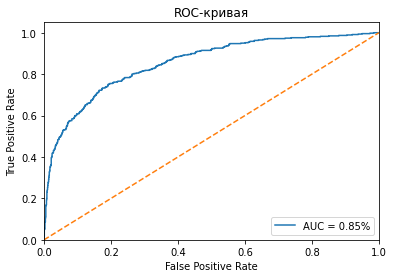

In [31]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

auc_roc = roc_auc_score(target_test, probabilities_one_test)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.2}%")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("ROC-кривая")
plt.legend(loc="lower right")
plt.show()

### Выводы

Модель случайного леса, обученная на увеличенной обучающей и валидационной выборках, показала на тестовой выборке значение `F1`-меры = 0.63. Значение метрики `AUC-ROC`, равное 0.85, говорит об очень хорошем качестве модели обучения.

## Общий вывод

На основе данных поведения клиентов банка были проведено обучение трех моделей: дерево решений, случайный лес и логистическая регрессия для возможности прогнозирования: уйдёт клиент из банка в ближайшее время или нет. Для каждой модели были определены гиперпараметры, позволяющие добиться лучшего значения `F1`-метрики.

Для повышения качества модели обучения была проведена балансировка классов тремя различными способами: взвешивание классов, увеличение числа объектов миноритарного класса и уменьшение числа объектов мажоритарного класса.  

Наилучшее качество показала модель случайного леса, состоящая из 80 деревьев с глубиной дерева, равной 15, обученная на увеличенной выборке. На тестовой выборке модель обучения достигла значения `F1`-меры = 0.63 и `AUC-ROC`-метрики = 0.85, что говорит об очень хорошем качестве модели.